# Use text for stock regression price prediction

- https://www.kaggle.com/code/lseiyjg/use-news-to-predict-stock-markets

In [40]:
import numpy as np
import torch

In [41]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


## Xử lí dữ liệu, tập trung vào lấy text của title, và giá đóng cửa của cổ phiếu trong ngày hôm đó

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import mysql.connector

# Establish a connection to the MySQL database
connection = mysql.connector.connect(
    host='127.0.0.1',
    port=13306,
    user='root',
    password='root',
    database='pyml'
)

# Read the table data using pandas
query = """
    SELECT title, content, date FROM crawl_data where domain = 'https://vneconomy.vn/kinh-te-the-gioi.htm'
    and date >= '2021-01-01' and date <= '2021-07-28'
"""
df = pd.read_sql(query, connection)

df['date_only'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m-%d')

from vnstock import *
from sklearn.model_selection import train_test_split

df_his = stock_historical_data('TPB', '2022-01-01', '2023-07-28', "1D", 'stock')
df_his['date'] = pd.to_datetime(df_his['time']).dt.strftime('%Y-%m-%d')


dfMerge = pd.merge(df, df_his, left_on=['date_only'], right_on=['date'], how='inner')
dfSumarize = dfMerge[['title', 'close', 'date_y']]

# Sorting the DataFrame by the 'date_column' in ascending order

df_sorted = dfSumarize.sort_values(by='date_y', ascending=True)
print(df_sorted.head())

SyntaxError: unterminated string literal (detected at line 14) (1484820029.py, line 14)

## Regress use phobert embedding và regression SVM để dự đoán gía stock dựa trên các bài viết của ngày hôm nay.
- Sau khi dự đoán giá stock, các bạn có thể lấy trung bình cộng để đưa ra con số chuẩn nhất cho gía đóng cửa của một mã stock (VD: TPB) nào đó.

In [128]:
import sys
sys.path.insert(0, '../algorithm')
import regress
from importlib import reload
reload(regress)

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

modelClass = regress.RergressionTextToPrice(transform_type='tfidf', algorithm='mlp')

x_train_raw = df_sorted['title']
y_train_raw = df_sorted['close']

modelClass.fit(x_train_raw, y_train_raw)

mlp (1258, 310) (1258,)
exp: [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.46154515 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] [[14470]
 [14470]
 [14470]
 ...
 [18550]
 [18550]
 [18700]]
Epoch 1/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 0.000

In [161]:
test = [
    'Lạm phát khiến Hàn Quốc giảm ngân sách lần đầu',
    '83 tỷ USD chảy khỏi thị trường trái phiếu Trung Quốc',
    '“Nóng ruột” với chính sách tiền tệ ở Mỹ, bà hoàng cổ phiếu Cathie Wood gửi thư nói “Fed đang mắc sai lầm”',
]

t = modelClass.predict(test)
print(t)


1/1 [==============================] - 0s 14ms/step
[[1.]
 [1.]
 [1.]]


(10, 15, 768)

In [203]:
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda, Embedding, LSTM, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.9, max_features = 200000, ngram_range = (1, 1))
x_train = vectorizer.fit_transform(x_train_raw).toarray()

y_train = y_train_raw.to_numpy().reshape(-1, 1).tolist()
scaler = MinMaxScaler(feature_range = (-1,1))
y_train = scaler.fit_transform(y_train)
print(y_train[:-5])

input_dim = x_train.shape[1]
nb_classes = 1
# Here's a Deep Dumb MLP (DDMLP)
modelDL = Sequential()
modelDL.add(Dense(256, input_dim=input_dim))
modelDL.add(Activation('relu'))
modelDL.add(Dropout(0.4))
modelDL.add(Dense(128))
modelDL.add(Activation('relu'))
modelDL.add(Dropout(0.4))
modelDL.add(Dense(nb_classes))
# modelDL.add(Activation('softmax'))
modelDL.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelDL.summary())
modelDL.fit(x_train, y_train)

[[-0.40030912]
 [-0.40030912]
 [-0.40030912]
 ...
 [ 0.86089645]
 [ 0.86089645]
 [ 0.9072643 ]]
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 256)               79616     
                                                                 
 activation_40 (Activation)  (None, 256)               0         
                                                                 
 dropout_120 (Dropout)       (None, 256)               0         
                                                                 
 dense_88 (Dense)            (None, 128)               32896     
                                                                 
 activation_41 (Activation)  (None, 128)               0         
                                                                 
 dropout_121 (Dropout)       (None, 128)               0         
                       

In [222]:
from keras_preprocessing.sequence import pad_sequences

y_train_arr_1 = y_train_raw.to_numpy().reshape(-1, 1).tolist()

X_train, X_test, Y_train, Y_test = train_test_split(x_train_raw, y_train_arr_1, test_size=0.2, shuffle=False)

scaler = MinMaxScaler(feature_range = (-1,1))
Y_train = scaler.fit_transform(Y_train)

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
max_len = 310
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len)

print('x train padded shape: ', X_train_padded.shape)

modelLM = Sequential()
modelLM.add(LSTM(units = 50,return_sequences = True, input_shape = (X_train_padded.shape[1],1)))
modelLM.add(Dropout(0.2))
modelLM.add(LSTM(units = 50,return_sequences = True))
modelLM.add(Dropout(0.2))
modelLM.add(LSTM(units = 50,return_sequences = True))
modelLM.add(Dropout(0.2))
modelLM.add(LSTM(units = 50))
modelLM.add(Dropout(0.2))
modelLM.add(Dense(units = 1, activation='linear'))
modelLM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelDL.summary())
modelDL.fit(X_train_padded, Y_train, epochs=100, batch_size=32, validation_split=0.2)

x train padded shape:  (1006, 310)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 256)               79616     
                                                                 
 activation_40 (Activation)  (None, 256)               0         
                                                                 
 dropout_120 (Dropout)       (None, 256)               0         
                                                                 
 dense_88 (Dense)            (None, 128)               32896     
                                                                 
 activation_41 (Activation)  (None, 128)               0         
                                                                 
 dropout_121 (Dropout)       (None, 128)               0         
                                                                 
 dense_89 (Dense) 

8/8 [==============================] - 1s 52ms/step
[[15482.867 ]
 [15389.905 ]
 [15475.703 ]
 [15465.262 ]
 [15539.89  ]
 [15393.291 ]
 [15524.322 ]
 [15458.172 ]
 [15352.662 ]
 [15496.998 ]
 [15575.903 ]
 [15418.969 ]
 [15527.282 ]
 [15429.06  ]
 [15461.407 ]
 [15620.197 ]
 [15502.59  ]
 [15404.813 ]
 [15392.025 ]
 [15583.652 ]
 [15612.711 ]
 [15318.688 ]
 [15371.493 ]
 [15516.845 ]
 [15500.526 ]
 [15381.507 ]
 [15398.474 ]
 [15594.732 ]
 [15430.716 ]
 [15463.192 ]
 [15463.989 ]
 [15497.617 ]
 [15392.248 ]
 [15504.248 ]
 [15345.506 ]
 [15513.007 ]
 [15544.834 ]
 [15401.723 ]
 [15640.291 ]
 [15471.525 ]
 [15478.401 ]
 [15305.595 ]
 [15576.418 ]
 [15337.073 ]
 [15389.776 ]
 [15438.866 ]
 [15363.029 ]
 [15350.673 ]
 [15530.427 ]
 [15471.56  ]
 [15608.377 ]
 [15348.752 ]
 [15432.031 ]
 [15510.584 ]
 [15424.439 ]
 [15539.249 ]
 [15475.898 ]
 [15483.143 ]
 [15464.721 ]
 [15384.953 ]
 [15330.381 ]
 [15303.886 ]
 [15384.023 ]
 [15559.637 ]
 [15506.82  ]
 [15387.981 ]
 [15382.22  ]
 [15609.16

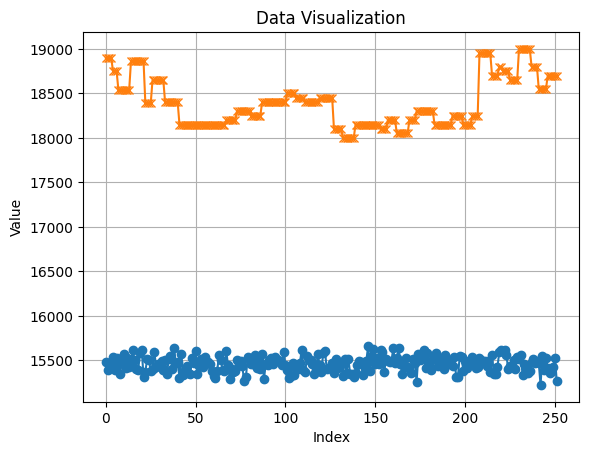

In [223]:

t = modelLM.predict(X_test_padded)
t1 = scaler.inverse_transform(t)
print(t1)

# Create a list of x-axis values (indices)
x_values = np.arange(len(t1))

import matplotlib.pyplot as plt
# Create the plot
plt.plot(x_values, t1, marker='o', linestyle='-')
plt.plot(x_values, Y_test, marker='x', linestyle='-')


plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Data Visualization')
plt.grid(True)

In [188]:


x_test = vectorizer.transform(test).toarray()
# t = modelDL.predict(x_test)
t = modelLM.predict(x_test)

t1 = scaler.inverse_transform(t)
print(t, t1)


1/1 [==============================] - 0s 46ms/step
[[-1.4331648e-03]
 [-5.4680891e-05]
 [-8.9904055e-04]
 [-2.0335612e-03]
 [-3.4286899e-03]
 [-7.2159246e-04]
 [-2.4229541e-06]
 [-2.6085152e-04]] [[15760.364]
 [15764.823]
 [15762.092]
 [15758.422]
 [15753.908]
 [15762.665]
 [15764.991]
 [15764.155]]
